In [698]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [699]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

# import kerastuner as kt
# print("kerastuner:", kt.__version__)

import keras_tuner as kt2
print("keras_tuner:", kt2.__version__)

import platform
print("Python:", platform.python_version())

import numpy as np
print("numpy:", np.__version__)

import pandas as pd
print("pandas:", pd.__version__)

import sklearn
print("sklearn version:", sklearn.__version__)

import sklearn
print("sklearn path:", sklearn.__path__)

import matplotlib
print("matplotlib:", matplotlib.__version__)

import seaborn as sns
print("seaborn:", sns.__version__) 

import tensorflow_decision_forests as tfdf
print("tensorflow_decision_forests:", tfdf.__version__)


Tensorflow: 2.15.0
keras_tuner: 1.3.5
Python: 3.10.12
numpy: 1.24.3
pandas: 2.1.4
sklearn version: 1.2.2
sklearn path: ['/home/michaelye22/.local/lib/python3.10/site-packages/sklearn']
matplotlib: 3.8.2
seaborn: 0.13.0
tensorflow_decision_forests: 1.8.1


## Set Global random seed to make sure we can replicate any model that we create (no randomness)

In [700]:
import random
import tensorflow as tf
import numpy as np
import os



np.random.seed(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

## **Load the Data from the Database**

In [701]:
#Remember to eventually clean up the wrong or missing values
train_data = pd.read_csv("train.csv")

#train_data.head()

In [702]:
#Remember to eventually clean up the wrong or missing values
test_data = pd.read_csv("test.csv")

#test_data.head()

## Set the target/label (y) values


In [703]:
#Y_train = pd.get_dummies(train_data["Survived"])
Y_train = train_data["Survived"]

#Y_train.head()


## Now I will re-initialize my data set and clean up my data before using pd.get_dummies()

**I set up X_train and Y_train, but this time, instead of doing pd.get_Dummies() on X_train, I'm not going to use pd.get_Dummies() until after I clean up the data**

In [704]:
train_data = pd.read_csv("train.csv")

features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"] # Here, I also added more features which I think might be useful


# print(train_data["Age"].isnull().sum())
# train_data = train_data.dropna(subset=["Age"]) # Drop the rows with missing values of age.
# print(train_data["Age"].isnull().sum())

# train_data = train_data.dropna(subset=["Embarked"]) # Drop the rows with missing values of Embarked
# print(train_data["Embarked"].isnull().sum())

X_train = train_data # I won't actually limit the X_train to just the columns of the features I want just yet. This is because I will use the other columns in the data set to help impute missing values

Y_train = train_data["Survived"]

#print(X_train.head())


## Start cleaning up the data

In [705]:
# Impute missing values for Pclass

average_Pclass = X_train["Pclass"].median()

X_train["Pclass"].fillna(average_Pclass, inplace = True)

print(X_train["Pclass"].isnull().sum()) # print the number of rows in the "Pclass" columns that now have no value

print(X_train["Sex"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Sex" column so we don't need to impute anything

print(X_train["Fare"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Fare" column so we don't need to impute anything

print(X_train["SibSp"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "SibSp" column so we don't need to impute anything

print(X_train["Parch"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Parch" column so we don't need to impute anything

print(X_train["Age"].isnull().sum()) # This prints out 177 so there are 177 rows with missing values in the "Age" column! This means we have to do a lot of imputing


#print(X_train["Embarked"].isnull().sum())



0
0
0
0
0
177


**From this, we learned that age is the main column with missing values (of the columns that we are working with) so we need to methodically impute those missing values**

## Cleaning up (imputing) the Age column using a Random Forest Regressor model (a type of Machine Learning model) that accurately predicts the age of a person given their information


I made it so that when ever you run this code, it will check to see if there is already imputed data (inside of the csv) and if there is, then the imputer won't run since it takes a long time and if the imputed already exists (from previous runs), then there's no point in running the imputer again (which is what I did before and it wasted so much time)

In [706]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

imputed_csv_path = 'X_train_imputed.csv'

if not os.path.exists(imputed_csv_path):
    # If CSV doesn't exist, run the imputation and save the results
   #We use "LabelEncoder" to turn all the categorial values (values which don't use numbers) into values which the Random Forest Regressor can understand more easily. This is very similar to doing something like pd.get_dummies()

    label_encoders = {}
    for column in ['Sex', 'Embarked']:
        label_encoders[column] = LabelEncoder()
        # We use 'astype(str)' to convert any NaN values to a string representation
        X_train[column] = label_encoders[column].fit_transform(X_train[column].astype(str))

    features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    # One very important thing that I will end up doing is using the "Survived" column of the dataset to predict the age. This is because there is a strong correleation between the survival and age. 


    #This is an imputer. It is a function that can efficiently impute values in the way you want. For this scenario, I am using IterativeImputer() and the RandomForestRegressor(() to )
    imputer = IterativeImputer(RandomForestRegressor(n_estimators=10), max_iter=100, random_state=42)


    # Fit the imputer on the DataFrame with the features
    imputer.fit(X_train[features]) #When IterativeImputer is used alongside an ML model like RandomForestRegressor, calling .fit() on the IterativeImputer() object will also fit (train) the ML model


    # Perform the imputation on the Training Data. THIS WILL ACTUAL IMPUTE ANY MISSING VALUES IN EACH ROW, not only the missing values in Age.
    X_train_imputed = imputer.transform(X_train[features])


    # Convert the output back to a DataFrame
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=features)

    # Update the original DataFrame with the imputed values. This means that the columns of the original X_train dataframe that weren't part of the features (like "Name" isn't apart of the features list)
    X_train[features] = X_train_imputed

    #print(X_train.head())


    # Save the imputed DataFrame to CSV
    X_train.to_csv(imputed_csv_path, index=False)
    print("I did imputation again")

else:
    # Load the imputed data from the CSV file
    X_train = pd.read_csv(imputed_csv_path)
    print("I used the data from the csv")
 

I used the data from the csv


**Using the ImperativeImputer(), this will actually impute all the missing values in each row. It won't only impute the missing values in the "age" column. BUT, since we already cleaned the data and know there are 0 missing values for all the other columns that we care about (the ones with the features we are using), the imputer will be imputing values only to the missing values of age and other columns that we don't care about, but out of all the columns we care about, it will only be affecting the age column since all the other columns we care about have 0 missing values as we checked in the code previously.**

In [707]:
features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

X_train = X_train[features]

#print(X_train.head(5))

#print((X_train["Sex"] == 0).sum())
#print((X_train["Sex"] == 1).sum())

# Since the dataset is 65% male, we can see from printing out the number of people with "sex equal to 0" and "sex equal to 1" that the LabelEncoder made Male into "1" and Female into "0". Now, let's change it back to "Male" and "Female".


# Check if 'Sex' column contains numeric values
if np.issubdtype(X_train['Sex'].dtype, np.number):
    # If 'Sex' column is numeric, map 0 to 'female' and 1 to 'male'
    X_train['Sex'] = X_train['Sex'].map({0: 'female', 1: 'male'})

    

if "Embarked" in features:
    X_train["Embarked"] = X_train["Embarked"].astype("category")
    X_train["Embarked"] = X_train["Embarked"].cat.codes

print(X_train)

     Pclass     Sex     Fare   Age  SibSp  Parch
0       3.0    male   7.2500  22.0    1.0    0.0
1       1.0  female  71.2833  38.0    1.0    0.0
2       3.0  female   7.9250  26.0    0.0    0.0
3       1.0  female  53.1000  35.0    1.0    0.0
4       3.0    male   8.0500  35.0    0.0    0.0
..      ...     ...      ...   ...    ...    ...
886     2.0    male  13.0000  27.0    0.0    0.0
887     1.0  female  30.0000  19.0    0.0    0.0
888     3.0  female  23.4500  24.8    1.0    2.0
889     1.0    male  30.0000  26.0    0.0    0.0
890     3.0    male   7.7500  32.0    0.0    0.0

[891 rows x 6 columns]


**Here, in the code above, I changed X_train back to focus only on the features we care about. I also changed the "Sex" column from 0 and 1 back to Male and Female.**

## After the careful inspection of the test.csv, I see that there are also missing values in the test.csv. As a result, we have to clean up the data for test.csv as we did for train.csv

**Seeing which columns have missing values:**

In [708]:
test_data = pd.read_csv("test.csv")

features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

print(test_data["Pclass"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Sex"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["SibSp"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Parch"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Fare"].isnull().sum()) # Since this is 1, that means there is one missing value

print(test_data["Age"].isnull().sum()) # Since this is 86, that means there are 86 missing values


0
0
0
0
1
86


**From this, we can see that only "Fare" annd "Age" have missing values. Since "Fare" only has one missing value, it's not worth it to go to through all the work to do some advanced imputation technique to fill in missing values. So, I will just fill that in with the average fare value.**

**For the "Age" feature, I will repeat the process of using an IterativeImputer and a RandomForestRegressor to imputate missing values**

In [709]:
average_fare = test_data["Fare"].mean()

test_data["Fare"].fillna(average_fare, inplace = True) # This replaces the single missing value in "Fare" with the average value Fare Value of the test data

print(test_data["Fare"].isnull().sum())

print(test_data["Age"].isnull().sum())

0
86


I made it so that when ever you run this code, it will check to see if there is already imputed data (inside of the csv) and if there is, then the imputer won't run since it takes a long time and if the imputed already exists (from previous runs), then there's no point in running the imputer again (which is what I did before and it wasted so much time)

In [710]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Your imputation code setup here...

# Path to the imputed CSV file
imputed_csv_path = 'test_data_imputed.csv'

# Check if the imputed data CSV file exists
if not os.path.exists(imputed_csv_path):
    # If CSV doesn't exist, run the imputation and save the results
    #We use "LabelEncoder" to turn all the categorial values (values which don't use numbers) into values which the Random Forest Regressor can understand more easily. This is very similar to doing something like pd.get_dummies()

    label_encoders = {}
    for column in ['Sex', 'Embarked']:
        label_encoders[column] = LabelEncoder()
        # We use 'astype(str)' to convert any NaN values to a string representation
        test_data[column] = label_encoders[column].fit_transform(test_data[column].astype(str))

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


    #This is an imputer. It is a function that can efficiently impute values in the way you want. For this scenario, I am using IterativeImputer() and the RandomForestRegressor(() to )
    imputer = IterativeImputer(RandomForestRegressor(n_estimators=10), max_iter=100, random_state=42)


    # Fit the imputer on the DataFrame with the features
    imputer.fit(test_data[features]) #When IterativeImputer is used alongside an ML model like RandomForestRegressor, calling .fit() on the IterativeImputer() object will also fit (train) the ML model


    # Perform the imputation on the Test Data. THIS WILL ACTUAL IMPUTE ANY MISSING VALUES IN EACH ROW, not only the missing values in Age.
    test_data_imputed = imputer.transform(test_data[features])


    # Convert the output back to a DataFrame
    test_data_imputed = pd.DataFrame(test_data_imputed, columns=features)

    # Update the original DataFrame with the imputed values. This means that the columns of the original test_data dataframe that weren't part of the features (like "Name" isn't apart of the features list)
    test_data[features] = test_data_imputed

    print(test_data["Age"].isnull().sum()) # Since this prints 0, we now know that there are 0 missing values in the age column and so the imputation was successful 

    print(test_data.head())

    # Save the imputed DataFrame to CSV
    test_data.to_csv(imputed_csv_path, index=False)

    print("I created a new CSV file with imputation")


else:
    # Load the imputed data from the CSV file
    test_data = pd.read_csv(imputed_csv_path)

    print("I used imputated data from previous csv")

print(test_data["Age"].isnull().sum()) # Since this prints 0, we now know that there are 0 missing values in the age column and so the imputation was successful 


I used imputated data from previous csv
0


**The code above will imputate all the missing values in the test_data**

## Finalize the cleaning of the data and make it so test_data only has the features we want

In [711]:
features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

test_data = test_data[features]

#print((test_data["Sex"] == 0).sum())
#print((test_data["Sex"] == 1).sum())

# Since the dataset is 65% male, we can see from printing out the number of people with "sex equal to 0" and "sex equal to 1" that the LabelEncoder made Male into "1" and Female into "0". Now, let's change it back to "male" and "female".

test_data['Sex'] = test_data['Sex'].map({0: 'female', 1: 'male'})

if "Embarked" in features:
    test_data["Embarked"] = test_data["Embarked"].astype("category")
    test_data["Embarked"] = test_data["Embarked"].cat.codes


print(test_data)

#print((test_data["Sex"] == "male").sum())

     Pclass     Sex      Fare        Age  SibSp  Parch
0       3.0    male    7.8292  34.500000    0.0    0.0
1       3.0  female    7.0000  47.000000    1.0    0.0
2       2.0    male    9.6875  62.000000    0.0    0.0
3       3.0    male    8.6625  27.000000    0.0    0.0
4       3.0  female   12.2875  22.000000    1.0    1.0
..      ...     ...       ...        ...    ...    ...
413     3.0    male    8.0500  26.892143    0.0    0.0
414     1.0  female  108.9000  39.000000    0.0    0.0
415     3.0    male    7.2500  38.500000    0.0    0.0
416     3.0    male    8.0500  26.892143    0.0    0.0
417     3.0    male   22.3583  12.815000    1.0    1.0

[418 rows x 6 columns]


## Now, after cleaning up the data, I can split up the data into train_validation_test 

In [712]:
from sklearn.model_selection import train_test_split

#Y_train = train_data["Survived"]

# First, split into training (60%) and a test set (40%)
train_X, test_X, train_Y, test_Y = train_test_split(X_train, Y_train, test_size=0.4, random_state = 42)

#Second, split test set into a validation (20%) and test set (20%)
valid_X, test_X, valid_Y, test_Y= train_test_split(test_X, test_Y, test_size = 0.5, random_state = 42)

## Using pd.get_dummies() on all the data

**Setting up the Test data (from Test.csv) (This is NOT the test data from the Train_validation_test split):**

In [713]:


test_data = pd.get_dummies(test_data)
#print(test_data.head())

**Setting up the Train data and Validation data and the Test data from the train_validation_test split:**

In [714]:
train_X = pd.get_dummies(train_X)
#print(train_X.head())

valid_X = pd.get_dummies(valid_X)
#print(valid_X.head())

test_X = pd.get_dummies(test_X)
#print(test_X.head())

## Feature Engineering: Putting more weight onto specific features (like Gender and Age)

**We know from history that Women and Children were more likely to survive so it makes more sense to put more weight into those features. In other words, we should penalize a person more if they are not a Women or Child and therefore make it less likely for them to survive**

In [715]:
#print(train_X)

child_age = 18 # Age 7: 0.03, 0.16, Age 8: 0.03, 0.15. Age 9: 0.03, 0.14. Age 10: 0.03, 0.10. Age 16: 0.08, 0.11. 

#Create a FemaleFirstClass and ChildFirstClass feature into each dataset
train_X['FemaleFirstClass'] = ((train_X['Sex_female'] == True) & (train_X['Pclass'] == 1)).astype(int)
#train_X['ChildFirstClass'] = ((train_X['Age'] < child_age) & (train_X['Pclass'] == 1)).astype(int) 


valid_X['FemaleFirstClass'] = ((valid_X['Sex_female'] == True) & (valid_X['Pclass'] == 1)).astype(int)
#valid_X['ChildFirstClass'] = ((valid_X['Age'] < child_age) & (valid_X['Pclass'] == 1)).astype(int) 


test_X['FemaleFirstClass'] = ((test_X['Sex_female'] == True) & (test_X['Pclass'] == 1)).astype(int)
#test_X['ChildFirstClass'] = ((test_X['Age'] < child_age) & (test_X['Pclass'] == 1)).astype(int) 


test_data['FemaleFirstClass'] = ((test_data['Sex_female'] == True) & (test_data['Pclass'] == 1)).astype(int)
#test_data['ChildFirstClass'] = ((test_data['Age'] < child_age) & (test_data['Pclass'] == 1)).astype(int) 


# Bin 'Age' into categories
# train_X['IsChild'] = (train_X['Age'] < child_age).astype(int)
# valid_X['IsChild'] = (valid_X['Age'] < child_age).astype(int)
# test_X['IsChild'] = (test_X['Age'] < child_age).astype(int)
# test_data['IsChild'] = (test_data['Age'] < child_age).astype(int)


#Create FamilySize and IsAlone
train_X['FamilySize'] = train_X['SibSp'] + train_X['Parch'] + 1
valid_X['FamilySize'] = valid_X['SibSp'] + valid_X['Parch'] + 1
test_X['FamilySize'] = test_X['SibSp'] + test_X['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1


train_X['IsAlone'] = (train_X['FamilySize'] == 1).astype(int)
valid_X['IsAlone'] = (valid_X['FamilySize'] == 1).astype(int)
test_X['IsAlone'] = (test_X['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)


#print(train_X)

## Normalizing all the data

**Creating the Normalizing Scaler**

In [716]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns you want to normalize
columns_to_normalize = ["Pclass", "Fare","Age", "SibSp"]

scaler.fit(train_X[columns_to_normalize]) #it is important to fit the scaler on the training data (from the train-validation-test split) only

# print(train_X)

MinMaxScaler()

**It is very important to only fit the scaler on the training data from the train-validation-test split and not the training data from the whole train.csv since the whole training data includes data from the validation and test split and fitting on that will cause the testing (using validation and test) of the model to be overly optimistic. This is called data leakage.**

**Also, it's important that we do not fit the scaler multiple times since that would cause inconsistant fitting throughout the data. It should only be fitted once and then applied to all the different datasets.**

**However,before I submit Model 4, I should re-fit the normalization scaler on the entire training data since I will be running my model on the entire training data**

**Normalizing the test data (the one from test.csv)**

In [717]:
test_data = test_data #the "test_data" variable here is after we cleaned up the test_data 

#print(test_data)

# Fit the scaler on the data and then transform it
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

#print(test_data)

**Normalizing the train, validation, and test data**

In [718]:
train_X[columns_to_normalize] = scaler.transform(train_X[columns_to_normalize])
#print(train_X.head())

valid_X[columns_to_normalize] = scaler.transform(valid_X[columns_to_normalize])
#print(valid_X.head())

test_X[columns_to_normalize] = scaler.transform(test_X[columns_to_normalize])
#print(test_X.head())

#print(train_X)

## I should re-fit the normalization scaler on the entire training data since I will be running my model on the entire training data


In [719]:
from sklearn.preprocessing import MinMaxScaler

training_X = pd.concat([train_X, valid_X, test_X], ignore_index=True) # training_X is the entire training data from train.csv but after all the cleaning, normalization, and feature engineering
training_Y = pd.concat([train_Y, valid_Y, test_Y], ignore_index=True) 


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

columns_to_normalize = ["Pclass", "Fare", "Age", "SibSp"]

scaler.fit(training_X[columns_to_normalize])

#print(training_X)

training_X[columns_to_normalize] = scaler.transform(training_X[columns_to_normalize])

#print(training_X)

## MAKE SURE THERE ISN'T ANY NEGATIVE VALUES FOR AGE BEFORE AND AFTER NORMALIZATION

In [720]:
negatives = training_X[training_X["Age"] < 0]
#print(negatives)

# No values negative values for age

# Change all the data to float32 so that it can be converted into tensor

In [721]:
train_X = train_X.astype('float32')
valid_X = valid_X.astype('float32')
test_X = test_X.astype('float32')
training_X = training_X.astype('float32')
training_X2 = training_X.astype('float32')

test_data2 = test_data.astype('float32')

# The Y values don't need to be converted to float or int since they are already integers (0 and 1) 

## Using different techniques to find the best features to have, including a correlation matrix and heatmap

In [722]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# full_data = pd.concat([training_X2, training_Y], axis = 1, ignore_index=False) #This is all the data (including the features and labels)

# #Making a correlation matrix
# corr_matrix = full_data.corr()

# #print(full_data)

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# # Save the figure
# plt.savefig('heatmap3.png')

# plt.show()

**From the correlation Matrix and heatmap, I think I want to remove FamilySize, and just let SibSp and Parch do it's thing. I also want to add ChildFirstClass and isChild**

## Creating age bins using matplotlib and finding out which young ages are more likely to survive 

In [723]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df = pd.read_csv("train.csv")

# # Assuming 'df' is your DataFrame and it has columns 'Age' and 'Survived'
# # Create age ranges

# bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
# labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80']
# df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# # Calculate mean survival rate for each age range
# age_survival = df.groupby('AgeRange')['Survived'].mean()

# # Plot
# age_survival.plot(kind='bar', figsize=(10, 6))
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Age Range')
# plt.show()

In [724]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df = pd.read_csv("train.csv")

# # Create age ranges of 1 year for ages 0-22
# bins = list(range(23))
# labels = [str(i) for i in range(22)]
# df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# # Calculate mean survival rate for each age range
# age_survival = df.groupby('AgeRange')['Survived'].mean()

# # Plot
# age_survival.plot(kind='bar', figsize=(10, 6))
# plt.ylabel('Survival Rate')
# plt.title('Survival Rate by Age Range')
# plt.show()

/tmp/ipykernel_321/3826917345.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = df.groupby('AgeRange')['Survived'].mean()


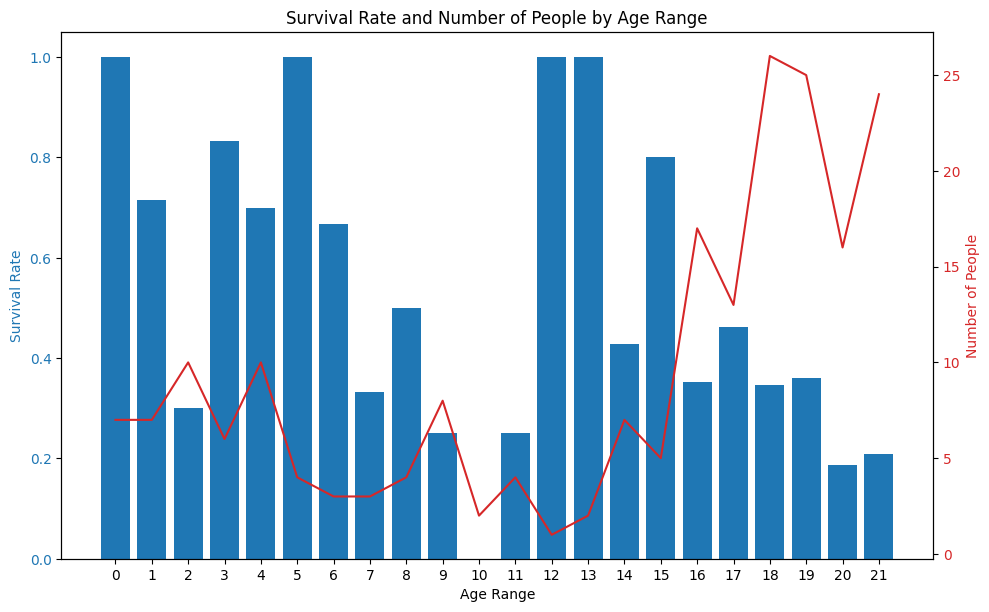

In [725]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

# Create age ranges of 1 year for ages 0-22
bins = list(range(23))
labels = [str(i) for i in range(22)]
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate mean survival rate for each age range
age_survival = df.groupby('AgeRange')['Survived'].mean()

# Calculate count of people in each age range
age_counts = df['AgeRange'].value_counts().sort_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Age Range')
ax1.set_ylabel('Survival Rate', color=color)
ax1.bar(age_survival.index, age_survival, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Number of People', color=color)  # we already handled the x-label with ax1
ax2.plot(age_counts.index, age_counts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Survival Rate and Number of People by Age Range')
plt.show()

## SelectKBest is a good tool to see what features are good to include

In [726]:
from sklearn.feature_selection import SelectKBest, f_classif


# Create the SelectKBest with the f_classif function. You can set the parameter "k" equal to a number if you want to limit the amount of features
selector = SelectKBest(f_classif)

# Fit the selector to the data
selector.fit(training_X2, training_Y)

# Get the boolean mask of the selected features
mask = selector.get_support()

# Get the names of the selected features
selected_features = training_X.columns[mask]

print(selected_features)



# Get the scores
scores = selector.scores_

# Create a DataFrame with the scores
features_scores = pd.DataFrame({'Feature': training_X2.columns, 'Score': scores})

# Sort the DataFrame by score in descending order
features_scores = features_scores.sort_values(by='Score', ascending=False)

print(features_scores)


Index(['Pclass', 'Fare', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male',
       'FemaleFirstClass', 'FamilySize', 'IsAlone'],
      dtype='object')
            Feature       Score
5        Sex_female  372.405731
6          Sex_male  372.405731
7  FemaleFirstClass  182.372589
0            Pclass  115.031143
1              Fare   63.030792
9           IsAlone   38.353794
2               Age    7.389521
4             Parch    5.963451
3             SibSp    1.110565
8        FamilySize    0.246159


## Trying out the TensorFlow Decision Forest (TFDF) and specifically trying the Random Forest

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

In [727]:
# import tensorflow_decision_forests as tfdf

# # Load a dataset
# #I wrote RF here which stands for Random Forest 

# train_RF_X = train_X
# train_RF_Y = train_Y
# train_RF = pd.concat([train_RF_X, train_RF_Y], axis = 1, ignore_index=False)

# test_RF_X = test_X
# test_RF_Y = test_Y
# test_RF = pd.concat([test_RF_X, test_RF_Y], axis =1, ignore_index=False)

# #print(test_RF)

# # Convert the pandas dataframe to a tensorflow dataset
# train_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(train_RF, label = "Survived", task=tfdf.keras.Task.CLASSIFICATION)

# test_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(test_RF, label = "Survived")

# # Train the model
# model1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION, random_seed=42) # MAKE SURE TO SET THE RANDOM SEED TO CONTROL THE RANDOMNESS

# model1.compile(metrics=["accuracy"])

# model1.fit(train_data_RF)

# evaluation1 = model1.evaluate(test_data_RF)

# print("Evaluation:", evaluation1) # prints out the accuracy of the model

# #model1.make_inspector().variable_importances() # Prints out information about the feature importance

# model1.summary() # This gives a VERY in-depth summary of the model. and NO NEED to call print() on it. It will automatically print. Actually, if you call print() on it, it will be differnet. summary() doesn't return a string, but it directly prints, so when you call print() on it, it will also print "none" since summary() returns none.

# # 1. **INV_MEAN_MIN_DEPTH**: This measure is based on the depth of a feature in the trees of the forest. A lower depth indicates higher importance. 
# # The value next to each feature is the average minimum depth of that feature across all trees, inverted (hence the name). 
# # Higher values indicate higher importance.

# # 2. **SUM_SCORE**: This measure is based on the improvement in the model's performance (measured by Gini impurity) that each feature provides when 
# # it is used in a split. The value next to each feature is the total improvement that feature provided across all trees. Higher values indicate
# # higher importance.

# # 3. **NUM_AS_ROOT**: This measure counts how many times each feature was used as the root of a tree (i.e., the first split). 
# # The value next to each feature is the number of trees where that feature was the root. Features that are often used as the root are typically 
# # important.

# # 4. **NUM_NODES**: This measure counts how many times each feature was used in a split, anywhere in any tree. The value next to each feature 
# # is the total number of splits that used that feature. Features that are used in many splits are typically important.


# # Use /tmp/tmpybu7i6xg as temporary training directory
# # Reading training dataset...
# # Training dataset read in 0:00:00.101229. Found 534 examples.
# # Training model...
# # Model trained in 0:00:00.080180
# # Compiling model...
# # Model compiled.
# # 1/1 [==============================] - 0s 58ms/step - loss: 0.0000e+00 - accuracy: 0.8324
# # Evaluation: [0.0, 0.832402229309082]
# # [INFO 23-12-19 22:51:10.4085 EST kernel.cc:1233] Loading model from path /tmp/tmpybu7i6xg/model/ with prefix 0585e4174b814fba
# # [INFO 23-12-19 22:51:10.4305 EST decision_forest.cc:660] Model loaded with 300 root(s), 27608 node(s), and 10 input feature(s).
# # [INFO 23-12-19 22:51:10.4305 EST abstract_model.cc:1344] Engine "RandomForestOptPred" built
# # [INFO 23-12-19 22:51:10.4305 EST kernel.cc:1061] Use fast generic engine

# # {'INV_MEAN_MIN_DEPTH': [("Age" (1; #0), 0.274571362611752),
# #   ("Fare" (1; #2), 0.26313833784215923),
# #   ("Sex_female" (1; #7), 0.21577160812501314),
# #   ("Pclass" (1; #6), 0.2035843854252375),
# #   ("Sex_male" (1; #8), 0.19269508777674002),
# #   ("FamilySize" (1; #1), 0.1445299038648969),
# #   ("FemaleFirstClass" (1; #3), 0.13908155788420232),
# #   ("SibSp" (1; #9), 0.1289757962146961),
# #   ("Parch" (1; #5), 0.12821342639540145),
# #   ("IsAlone" (1; #4), 0.12117983915114254)],
# #  'SUM_SCORE': [("Age" (1; #0), 19183.879066010122),
# #   ("Fare" (1; #2), 17967.80573042354),
# #   ("Sex_female" (1; #7), 12829.28466653265),
# #   ("Sex_male" (1; #8), 11226.850867390633),
# #   ("Pclass" (1; #6), 9453.17268255452),
# #   ("FamilySize" (1; #1), 3231.1449760415126),
# #   ("FemaleFirstClass" (1; #3), 2497.339019147679),
# #   ("SibSp" (1; #9), 1429.196950293146),
# #   ("Parch" (1; #5), 1207.8541804915876),
# #   ("IsAlone" (1; #4), 411.8059418700286)],
# #  'NUM_AS_ROOT': [("Sex_female" (1; #7), 129.0),
# #   ("Sex_male" (1; #8), 101.0),
# #   ("FemaleFirstClass" (1; #3), 40.0),
# #   ("Fare" (1; #2), 15.0),
# #   ("Pclass" (1; #6), 13.0),
# #   ("IsAlone" (1; #4), 1.0),
# #   ("Parch" (1; #5), 1.0)],
# #  'NUM_NODES': [("Age" (1; #0), 5723.0),
# #   ("Fare" (1; #2), 5205.0),
# #   ("Pclass" (1; #6), 721.0),
# #   ("FamilySize" (1; #1), 717.0),
# #   ("SibSp" (1; #9), 373.0),
# #   ("Parch" (1; #5), 320.0),
# #   ("Sex_female" (1; #7), 178.0),
# #   ("Sex_male" (1; #8), 157.0),
# #   ("IsAlone" (1; #4), 155.0),
# #   ("FemaleFirstClass" (1; #3), 105.0)]}


## Using tfdf.model_plotter.plot_model() to create an HTML file which will visualize your model

In [728]:


# html = tfdf.model_plotter.plot_model(model1)
# with open('model_plot.html', 'w') as f: # MAKE SURE TO CHANGE THE FILE NAME TO SOMETHING OTHER THAN 'model_plot.html' IF YOU WANT TO VISUALIZE ANOTHER MODEL
#     f.write(html)
    

## Testing out OOB (Out-of-bag) Evaluation

**Out-of-bag (OOB) Evaluation**: In a Random Forest, each tree is trained on a bootstrap sample of the data. This means that for each tree, there is a sample of the data (the "out-of-bag" sample) that was not used in training that tree. OOB evaluation involves making predictions for each data point using only the trees that did not have that data point in their bootstrap sample. This provides an unbiased estimate of the model performance, and can be a useful alternative to cross-validation.

OOB doesn't affect the model at all. It just provides a useful set of data. So, there is no harm in setting oob_score = True

In [729]:
# import tensorflow_decision_forests as tfdf

# # Load a dataset
# #I wrote RF here which stands for Random Forest 

# train_RF_X = train_X
# train_RF_Y = train_Y
# train_RF = pd.concat([train_RF_X, train_RF_Y], axis = 1, ignore_index=False)

# test_RF_X = test_X
# test_RF_Y = test_Y
# test_RF = pd.concat([test_RF_X, test_RF_Y], axis = 1, ignore_index=False)

# #print(test_RF)

# # Convert the pandas dataframe to a tensorflow dataset
# train_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(train_RF, label = "Survived", task=tfdf.keras.Task.CLASSIFICATION)

# test_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(test_RF, label = "Survived")

# # Train the model
# model2 = tfdf.keras.RandomForestModel(compute_oob_performances = True, compute_oob_variable_importances=True, random_seed=42, verbose = 1) # MAKE SURE TO SET THE RANDOM SEED TO CONTROL THE RANDOMNESS

# model2.compile(metrics=["accuracy"]) # Compiling allows you to choose which metrics you want to grade the model on

# model2.fit(train_data_RF) 

# evaluation2 = model2.evaluate(test_data_RF)


# print("Evaluation:", evaluation2) # prints out the accuracy of the model

# # Get the OOB variable importances
# oob_variable_importances = model2.make_inspector().variable_importances()
# print("OOB Variable Importances:", oob_variable_importances)

# # Get the evaluation results from OOB samples
# evaluations = model2.make_inspector().evaluation() # This calculates data based on the OOB samples
# print("OOB evaluation:", evaluations)

## Hyper Parameter Tuning 
**(https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab)**

**Basically, TFDF is great because it has it's own Tuning classes and you can use it's own Tuning. BUT, it's also compatible with Keras tuner so I will try out both**

### I'm going to be testing out the RandomSearch tuner first, with automatic hyperparameter space so that it tries out it's own set of hyperparameters

In [730]:
import tensorflow_decision_forests as tfdf
import os
from tensorflow.keras.models import load_model


%pip install wurlitzer -U -qq # This will automatically install wurlitzer when you run this notebook



if os.path.isdir("model3_RF"): # If the model already exists (inside a directory named model3_RF)
    model3 = load_model("model3_RF") # set model3 equal to this already existing model


else: # if the model3 doesn't exist already, create it
    train_RF_X = pd.concat([train_X, valid_X], ignore_index=True)  
    train_RF_Y = pd.concat([train_Y, valid_Y], ignore_index=True)
    train_RF = pd.concat([train_RF_X, train_RF_Y], axis = 1, ignore_index = False)

    test_RF_X = test_X
    test_RF_Y = test_Y
    test_RF = pd.concat([test_RF_X, test_RF_Y], axis = 1, ignore_index = False)


    train_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(train_RF, label = "Survived", task = tfdf.keras.Task.CLASSIFICATION)

    test_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(test_RF, label = "Survived")


    #This is a TensorFlow Decision Forest Tuner. I am using RandomSearch since it might be the only one, and also because I want it to be fast
    tuner3 = tfdf.tuner.RandomSearch(num_trials=200, use_predefined_hps=True, trial_num_threads = 1) # num_trials = 200 and trial_num_threads = 1 took 1 min 5 sec.


    #Now I make the model and do .fit() on it since .fit() will cause the tuner to run and find the best hyperparameters
    # MAKE SURE TO SET THE "tuner" PARAMETER IN ORDER FOR THE TUNER TO RUN
    model3 = tfdf.keras.RandomForestModel(tuner = tuner3, compute_oob_performances = True, compute_oob_variable_importances = True, random_seed = 42, verbose = 1, task = tfdf.keras.Task.CLASSIFICATION)

    model3.compile(["accuracy"])

    model3.fit(train_data_RF, verbose = 1)

    model3.save("model3_RF")


    # Display the tuning logs
    tuning_logs = model3.make_inspector().tuning_logs()
    tuning_logs.head()


    # Make sure to either save the model or save all the hyper parameters of the model since we used RandomSearch() 
    # here so if we run the code again, we will get a totally different model!

    # Best hyper-parameters
    print(tuning_logs[tuning_logs.best].iloc[0])



    # these lines below will save the best hyperparameters to a JSON file that will be stored in a file, so that I can always look back at it incase I want to replicate this model and it's results
    import json

    best_hyperparameters = tuning_logs[tuning_logs.best].iloc[0].to_dict() # convert to a dictionary so that you can convert it to a JSON

    # Save the best hyperparameters to a file
    with open('model3_RF_hyperparameters.json', 'w') as f:
        json.dump(best_hyperparameters, f)


        

    # these lines basically saves the ".summary()" method into a file so that I can use it later if I want to replicate this model
    import sys

    with open('model3_RF_summary.txt', 'w') as f: 
        old_stdout = sys.stdout  # Save the original standard output
        sys.stdout = f  # Redirect standard output to the file

        model3.summary()  # This will be written to the file. Basically, by changing the standard output, this will print the summary in my file INSTEAD of inside the jupyter notebook. The standard output dictates where the print outputs go

        sys.stdout = old_stdout  # Restore the original standard output



Note: you may need to restart the kernel to use updated packages.


[INFO 23-12-22 22:03:48.9257 EST kernel.cc:1233] Loading model from path model3_RF/assets/ with prefix 5ef38110fea44ee6


[INFO 23-12-22 22:04:01.4212 EST decision_forest.cc:660] Model loaded with 300 root(s), 26676 node(s), and 10 input feature(s).
[INFO 23-12-22 22:04:01.4212 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-12-22 22:04:01.4213 EST kernel.cc:1061] Use fast generic engine


### This is a cool way to see the best trial performance in a graph

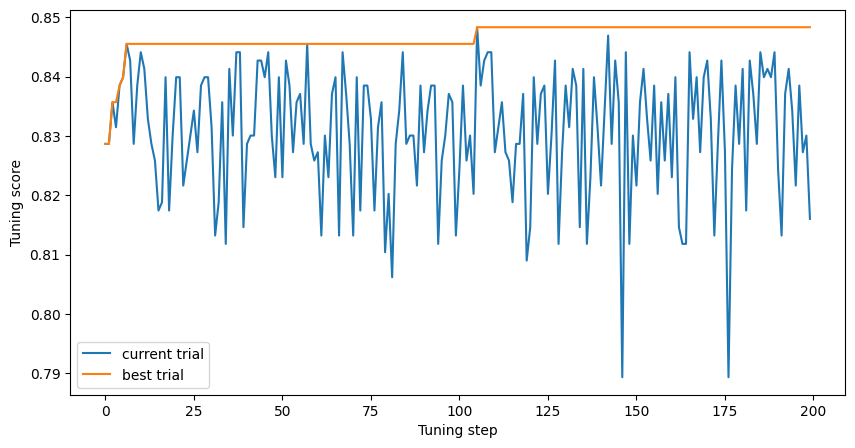

In [731]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

## Submitting Model 3. Score: 77.2

In [732]:
# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# test_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(test_data2, task = tfdf.keras.Task.CLASSIFICATION)

# predictions3 = model3.predict(test_data_RF) #This is the model that's only trained on the train_X and valid_X. If I want to train on test_X as well, I have to manually set the hyperparameters and then re-fit the model


# #Since this is a classification task, the output will be the probabilities for each class. 
# # You can convert these probabilities to class labels by choosing the class with the highest probability. 
# # In the case of the Titanic dataset, you're predicting whether a passenger survived or not, so you can simply round the probabilities to 
# # get the class labels:

# # predictions3 = predictions3.round().astype(int)

# predictions3 = (predictions3 > 0.45).astype("int32")

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions3 = predictions3.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions3})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## Try re-fitting the model on the entire training data before predicting and submitting. Score: 76.55

In [733]:
# import json

# with open('model3_RF_hyperparameters.json', 'r') as f:
#     best_hyperparameters = json.load(f)

model3 = tfdf.keras.RandomForestModel(
    random_seed = 42, # ALWAYS REMEMBER THE RANDOMSEED
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_projection_density_factor=2.0,
    sparse_oblique_normalization="STANDARD_DEVIATION",
    sparse_oblique_weights="BINARY",
    categorical_algorithm="CART",
    winner_take_all=True,
    max_depth=12,
    min_examples=5,
    task=tfdf.keras.Task.CLASSIFICATION
)

training_full = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([training_X2, training_Y], axis = 1, ignore_index = False), label = "Survived", task=tfdf.keras.Task.CLASSIFICATION)

model3.fit(training_full, verbose = 1)

if "PassengerId" in test_data2.columns:
    test_data2 = test_data2.drop("PassengerId", axis = 1)

test_data_RF = tfdf.keras.pd_dataframe_to_tf_dataset(test_data2, task = tfdf.keras.Task.CLASSIFICATION)

predictions3 = model3.predict(test_data_RF) #This is the model that's only trained on the train_X and valid_X. If I want to train on test_X as well, I have to manually set the hyperparameters and then re-fit the model


#Since this is a classification task, the output will be the probabilities for each class. 
# You can convert these probabilities to class labels by choosing the class with the highest probability. 
# In the case of the Titanic dataset, you're predicting whether a passenger survived or not, so you can simply round the probabilities to 
# get the class labels:

# predictions3 = predictions3.round().astype(int)

predictions3 = (predictions3 > 0.5).astype("int32")

original_test = pd.read_csv("test.csv")

pass_id = original_test['PassengerId']

test_data2["PassengerId"] = pass_id

#Flatten out predictions so that we make sure it's a 1D array

predictions3 = predictions3.reshape(-1)

output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions3})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

Use /tmp/tmp85rdbgnb as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.131010. Found 891 examples.
Training model...
Model trained in 0:00:00.652802
Compiling model...
Model compiled.
1/1 [==============================] - 0s 35ms/step
Your submission was successfully saved!


[INFO 23-12-22 22:04:02.3857 EST kernel.cc:1233] Loading model from path /tmp/tmp85rdbgnb/model/ with prefix caf14d7c9dbd48bb
[INFO 23-12-22 22:04:02.4130 EST decision_forest.cc:660] Model loaded with 300 root(s), 32362 node(s), and 10 input feature(s).
[INFO 23-12-22 22:04:02.4130 EST kernel.cc:1061] Use fast generic engine


## LAST THING: Work with XGBoost and then move onto next project

## Recursive feature elimination (from scikit learn) is another great tool to see what the best features are 

## When you do kerastuner, make sure to change the "project name" attribute and maybe even the "directory" attribute since this indicates that you are making a fresh new keras tuner

**Play around with the threshold some more and then also try adding/removing some more feature engineering. Also try playing with the epochs on the fitting and also whether to build new model or use the one from keras.**

**After that, use advanced techniques to try to find the best features**

**1. Another thing i want to try is seeing if removing some of the feature enginering will help, since I removed some in the randomforestclassifier and it improved the model**

**2. Another thing to look into is the kernel_initializer since those are how the model finds the initial value for the weights in each layer so look into that**

**4. Try Keras Tuner with the Bayesian Optimizer instead of hyperband**

**5. Earlier, I use a random forest classifier to fill in the missing data for whether someone was a male or female. Maybe try optimizing that or just removing the rows of data for which gender is missing. Maybe do the same for the other columns with missing values**

**7. Try Random forest classifier on tensor flow. Also try XGBoost**

**8. Maybe try optimizing the age imputer using tensorflow neural network or random forest classifier**

**9. Try looking into different ways to see which features are best to choose from, like using correlation matrix or Scikit learn SelectKBest**

**10. Research more about the pipeline and see if you can use it. Also, research about the XGBoost**

**11. Look into the validation_data parameter of the .fit() method for the tfdf models, since that might be very helpful for training**